In [23]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

### Starting with creating partitions

In [24]:
PATH_DATAFRAME_PRETRAIN = "/home/trigger/Documents/Bio_Medical_Project/" # this is where you save the CSV file
PATH_DATASETS= "//home/trigger/Documents/Bio_Medical_Project/" # this is where the dataset folder is saved
def create_dataset_partition():
    path_dataset = "DeepEyeNet/" 
    path_dataset_mask = "DeepEyeNetBW/" 
    data = []

    partitions = ["DeepEyeNet_train.json", "DeepEyeNet_test.json", "DeepEyeNet_valid.json"]
    for iPartition in partitions:
        f = open(PATH_DATASETS + path_dataset + iPartition)
        meta = json.load(f)

        for iSample in meta:
            image_name = list(iSample.keys())[0]
            #print(image_name)
            image_path = os.path.join(path_dataset, image_name)
            mask_path = os.path.join(path_dataset_mask, image_name)
            
            categories, atributes = [], []
            info = iSample[list(iSample.keys())[0]]
            categories.extend(info["keywords"].split(", "))
            categories.extend(info["clinical-description"].split(". "))
            
            
            if "" in categories:
                categories.remove("")

            if os.path.isfile(PATH_DATASETS + image_path) and os.path.isfile(PATH_DATASETS + mask_path):


                data.append({"image": image_path,
                             "mask": mask_path,
                             "atributes": atributes,
                             "categories": categories})
            
    df_out = pd.DataFrame(data)
    df_out.to_csv(PATH_DATAFRAME_PRETRAIN + "DEN.csv")
    print("CSV Created")


#create_dataset_partition()


Total rows: 15710


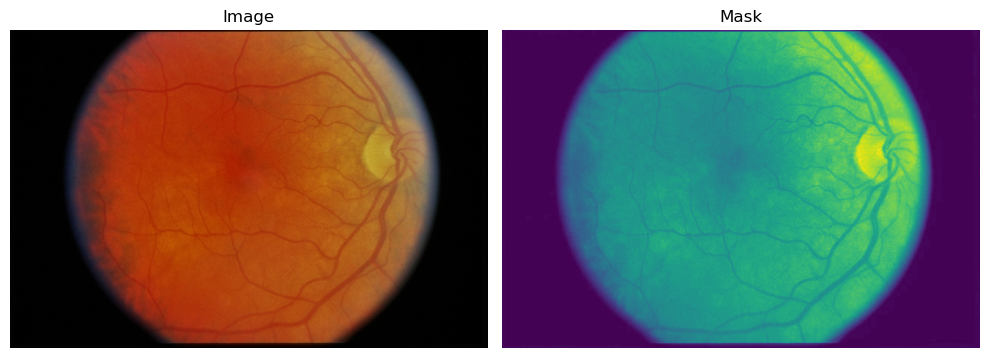

In [25]:
csv_path = os.path.join(PATH_DATASETS, "DEN.csv")

df = pd.read_csv(csv_path)

# Check how many valid rows we have
print(f"Total rows: {len(df)}")

# Pick the first valid image+mask pair
for idx, row in df.iterrows():
    image_path = os.path.join(PATH_DATASETS, row["image"])
    mask_path = os.path.join(PATH_DATASETS, row["mask"])

    if os.path.isfile(image_path) and os.path.isfile(mask_path):
        # Load image and mask
        img = Image.open(image_path)
        mask = Image.open(mask_path)  # grayscale mask

        # Plot
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask)
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # just show one
    else:
        print(f"Missing file:\n - {image_path}\n - {mask_path}")

### Dataloader 

In [26]:
import pandas as pd

from torchvision.transforms import Compose
from torch.utils.data import DataLoader

from flair.pretraining.data.dataset import Dataset, UniformDataset

from flair.pretraining.data.transforms import LoadImage,LoadMask ,ImageScaling, SelectRelevantKeys, CopyDict,\
    ProduceDescription, AugmentDescription



In [27]:
dataframes_path = "/home/trigger/Documents/Bio_Medical_Project/"
data_root_path = "/home/trigger/Documents/Bio_Medical_Project/"
mask_root_path = "/home/trigger/Documents/Bio_Medical_Project/"
datasets = ["DEN"]


In [28]:
def get_loader(dataframes_path, data_root_path, mask_root_path ,datasets, balance=False, batch_size=8, num_workers=0,
               banned_categories=None, caption="A fundus photograph of [CLS]", augment_description=True):

    """
    Dataloaders generation for vision-language pretraining. Read all dataframes from assembly model and combines
    them into a unified dataframe. Also, a dataloader is conditioned for training.
    """

    # Prepare data sample pre-processing transforms
    transforms = Compose([
        CopyDict(),
        LoadImage(),
        #########################################################
        #########################################################
        LoadMask(), #### THIS WE ADDED FROM TRANSFORM.PY
        #########################################################
        #########################################################
        ImageScaling(),
        ImageScaling(target='mask'),
        ProduceDescription(caption=caption),
        AugmentDescription(augment=augment_description),
        SelectRelevantKeys()

    ])

    # Assembly dataframes into a combined data structure
    print("Setting assebly data...")
    data = []
    check = True
    for iDataset in datasets:
        print("Processing data: " + iDataset)

        dataframe = pd.read_csv(dataframes_path + iDataset + ".csv")

        for i in range(len(dataframe)):
            data_i = dataframe.loc[i, :].to_dict()
            data_i["categories"] = eval(data_i["categories"])
            data_i["atributes"] = eval(data_i["atributes"])

            # Remove banned words - for evaluating on incremental categories
            banned = False
            if banned_categories is not None:
                for iCat in data_i["categories"]:
                    for iiCat in banned_categories:
                        if iiCat in iCat:
                            banned = True
            if banned:
                continue

            # Add sample to general data
            data_i["image_name"] = data_i["image"]
            data_i["image_path"] = data_root_path + data_i["image"]

            #########################################################
            #########################################################
            data_i["mask_name"] = data_i["mask"]
            data_i["mask_path"] = mask_root_path + data_i["mask"]
            #########################################################
            #########################################################
            
            data.append(data_i)
            if check:
                print(data)
                check = False

    print('Total assembly data samples: {}'.format(len(data)))

    # Set data
    if balance:
        train_dataset = UniformDataset(data=data, transform=transforms)
    else:
        train_dataset = Dataset(data=data, transform=transforms)
    print(f"Dataset length: {len(train_dataset)}")


    # Set dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Set dataloaders in dict
    datalaoders = {"train": train_loader}

    return datalaoders


In [29]:
X = get_loader(dataframes_path, data_root_path, mask_root_path ,datasets)

Setting assebly data...
Processing data: DEN
[{'Unnamed: 0': 0, 'image': 'DeepEyeNet/eyenet0420/train_set/group41-174.jpg', 'mask': 'DeepEyeNetBW/eyenet0420/train_set/group41-174.jpg', 'atributes': [], 'categories': ['macular hole', '43-year-old female, macular hole,'], 'image_name': 'DeepEyeNet/eyenet0420/train_set/group41-174.jpg', 'image_path': '/home/trigger/Documents/Bio_Medical_Project/DeepEyeNet/eyenet0420/train_set/group41-174.jpg', 'mask_name': 'DeepEyeNetBW/eyenet0420/train_set/group41-174.jpg', 'mask_path': '/home/trigger/Documents/Bio_Medical_Project/DeepEyeNetBW/eyenet0420/train_set/group41-174.jpg'}]
Total assembly data samples: 15710
Dataset length: 15710


In [30]:
check = True
for batch in X['train']:
    if not check:
        break
    check = False
    print(batch.keys())  # check if 'mask' is in the batch dict
    if 'mask' in batch:
        print("Mask batch shape:", batch['mask'].shape, batch['image'].shape)
      # just one batch for checking

dict_keys(['image', 'mask', 'report', 'sel_category'])
Mask batch shape: torch.Size([8, 1, 512, 512]) torch.Size([8, 3, 512, 512])


### Model

In [31]:
import torch
import torchvision
import numpy as np
import os

#from .dictionary import definitions
from flair.modeling.dictionary import definitions 
#from . import constants
import flair.modeling.constants 

from flair.modeling.misc import wget_gdrive_secure

from torch.cuda.amp import autocast
from tqdm import tqdm
from pathlib import Path
from transformers import AutoModel, AutoTokenizer, logging
logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Device for training/inference
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [32]:
class FLAIRModel(torch.nn.Module):
    def __init__(self, vision_type='resnet_v1', bert_type='emilyalsentzer/Bio_ClinicalBERT', vision_pretrained=True,
                 proj_dim=512, proj_bias=False, logit_scale_init_value=0.07, from_checkpoint=True, weights_path=None,
                 out_path=None, image_size=512, caption="A fundus photograph of [CLS]", projection=True,
                 norm_features=True):
        super().__init__()

        # Set attributes
        self.vision_type = vision_type
        self.bert_type = bert_type
        self.vision_pretrained = vision_pretrained
        self.proj_dim = proj_dim
        self.proj_bias = proj_bias
        self.logit_scale_init_value = logit_scale_init_value
        self.from_checkpoint = from_checkpoint
        self.weights_path = weights_path
        self.out_path = out_path
        self.image_size = image_size
        self.caption = caption
        # Use of projection head and feature normalization on visione encoder
        # (only relevant during transferability stage)
        self.projection = projection
        self.norm_features = norm_features

        # Set vision and text encoder
        self.vision_model = VisionModel(vision_type=self.vision_type, pretrained=self.vision_pretrained,
                                        proj_dim=self.proj_dim, proj_bias=self.proj_bias, projection=self.projection,
                                        norm=self.norm_features)
        self.text_model = TextModel(bert_type=self.bert_type, proj_dim=self.proj_dim, proj_bias=self.proj_bias,
                                    projection=self.projection, norm=self.norm_features)

        # learnable temperature for contrastive loss
        self.logit_scale = torch.nn.Parameter(torch.log(torch.tensor(1/self.logit_scale_init_value)))

        # Load pretrained weights
        if from_checkpoint:
            self.load_from_pretrained(self.weights_path)

        # Set model to device
        self.to(device)

    def load_from_pretrained(self, weights_path=None):

        if weights_path is None:
            import zipfile

            input_dir = constants.PATH_PRETRAINED_WEIGHTS
            pretrained_id = constants.ID_FLAIR_RESNET_V1
            pretrained_url_id = constants.URL_ID_FLAIR_RESNET_V1
            weights_path = input_dir + pretrained_id

            if not os.path.exists(input_dir + pretrained_id):
                if not os.path.exists(input_dir):
                    Path(input_dir).mkdir(parents=True, exist_ok=True)

                # download url link
                wget_gdrive_secure(pretrained_url_id, input_dir, filename="weights.zip")

                # unzip
                zipf = zipfile.ZipFile(input_dir + "weights.zip")
                zipf.extractall(input_dir)
                zipf.close()
                print('\n Download model to:', input_dir + pretrained_id)

        state_dict = torch.load(weights_path)
        self.load_state_dict(state_dict, strict=False)
        print('load model weight from:', weights_path)

    def softce_clip_loss(self, logits_per_text, target_pseudo):
        caption_loss = self.ce_loss(logits_per_text, target_pseudo)
        image_loss = self.ce_loss(logits_per_text.T, target_pseudo)
        return (caption_loss + image_loss) / 2.0

    def ce_loss(self, pred_logit, ref):
        ce_loss = torch.nn.functional.cross_entropy(pred_logit, ref)
        return ce_loss

    def compute_logits(self, img_emb, text_emb):
        self.logit_scale.data = torch.clamp(self.logit_scale.data, 0, 4.6052)
        logit_scale = self.logit_scale.exp()
        logits_per_text = torch.matmul(text_emb, img_emb.t()) * logit_scale
        return logits_per_text.t()

    def fit(self, datalaoders, epochs=30, lr=5e-4, weight_decay=1e-5, scheduler=True, warmup_epoch=1, store_num=5,
            transforms=None):

        # Set optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Set scheduler
        if scheduler:
            from flair.pretraining.utils import get_scheduler_per_iteration
            scheduler = get_scheduler_per_iteration(optimizer, lr, warmup_epoch, len(datalaoders["train"]))
        else:
            scheduler = None

        # Training along epochs
        epoch = 1
        while epoch <= epochs:

            # Train epoch
            loss_epoch = self.train_epoch(datalaoders["train"], optimizer, scheduler, transforms, epoch)

            # Display epoch-wise loss
            print('Epoch=%d: ave_loss=%2.5f' % (epoch, loss_epoch))

            # Save model
            if epoch % store_num == 0:
                if self.out_path is not None:
                    if not os.path.isdir(self.out_path):
                        os.mkdir(self.out_path)
                    torch.save(self.state_dict(), self.out_path + self.vision_type + '_epoch_seg' + str(epoch) + '.pth')

            # Update epoch
            epoch += 1

    def train_epoch(self, loader, optimizer, scheduler=None, transforms=None, epoch=1):
        self.train()
        max_grad_norm, scaler = 1, torch.cuda.amp.GradScaler()
        loss_ave = 0.0

        # Set iterator
        epoch_iterator = tqdm(
            loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
        )

        # Iterate trough training batches
        for step, batch in enumerate(epoch_iterator):
            # Retrieve documents
            images = batch["image"].to(device).to(torch.float32)
            ####################################################
            ####################################################
            masks = batch["mask"].to(device).to(torch.float32)
            ####################################################
            ####################################################
            
            # Create text tokens
            text_tokens = self.text_model.tokenize(list(batch["report"][0]))
            input_ids = text_tokens["input_ids"].to(device).to(torch.long)
            attention_mask = text_tokens["attention_mask"].to(device).to(torch.long)

            # Create similarity matrix with soft labels as ground truth
            coocurrence = np.array(
                [[iDesc == iiDesc for iDesc in batch["sel_category"]] for iiDesc in batch["sel_category"]], np.float32)
            target = torch.tensor(coocurrence / coocurrence.sum(-1)).to(device).to(torch.float32)

            # Forward
            with autocast():

                # Image augmentation
                if transforms is not None:
                    images = transforms(images)
                    masks = transforms(masks)

                # Forward vision and text encoder
                ###################################################
                ###################################################
                images = torch.cat([images,masks], dim=1)
                ###################################################
                ###################################################
                
                img_embeds = self.vision_model(images) 
                
                text_embeds = self.text_model(input_ids, attention_mask)

                # Compute similarity matrix and logits
                logits_per_image = self.compute_logits(img_embeds, text_embeds)
                logits_per_text = logits_per_image.t()

                # Compute cross-entropy loss
                loss = self.softce_clip_loss(logits_per_text, target)

            # Update model with scaler
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Overall losses track
            loss_ave += loss.item()
            torch.cuda.empty_cache()

            # Set description
            epoch_iterator.set_description(
                "Epoch=%d: Training (%d / %d Steps) " % (epoch, step + 1, len(loader)) +
                "- loss_value: " + str(round(loss.item(), 3))
            )

            # Update optimizer scheduler
            if scheduler is not None:
                scheduler.step()

        self.eval()
        return loss_ave / len(loader)

    def forward(self, image, mask, text):
        self.eval()

        # Pre-process image
        image = self.preprocess_image(image)
        mask = self.preprocess_mask(mask)

        image = torch.cat([image,mask], dim=1)
        
        # Pre-process text
        text_input_ids, text_attention_mask = self.preprocess_text(text)

        # Forward vision and text encoder
        with torch.no_grad():
            img_embeds = self.vision_model(image)
            text_embeds = self.text_model(text_input_ids, text_attention_mask)

            # Compute similarity matrix and logits
            logits = self.compute_logits(img_embeds, text_embeds)

            # Compute probabilities
            probs = logits.softmax(dim=-1)

        return probs.cpu().numpy(), logits.cpu().numpy()
        
    def preproces_mask(self, mask):
        
        if mask.dtype != np.float32:
            mask = np.float32(mask)

        # Intensity scaling
        if mask.max() > 0:
            mask /= 255

        # Channel first
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, 0)
        elif mask.shape[0] != 1:
            raise ValueError("MASKS ARE SINGLE CHANNEL, YOU IDIOT")
            

        # Batch dimension
        mask = np.expand_dims(mask, 0)

        # Resize to training size using a canvas
        mask = torch.tensor(mask)
        sizes = mask.shape[-2:]
        max_size = max(sizes)
        scale = max_size / self.image_size
        mask = torchvision.transforms.Resize((int(mask.shape[-2] / scale), int((mask.shape[-1] / scale))))(mask)

        
        mask = torch.nn.functional.pad(mask,
                                       (0, self.image_size - mask.shape[-1],
                                        0, self.image_size - mask.shape[-2],
                                        0, 0))

        # Set format and device
        mask = mask.to(torch.float32).to(device)

        return mask
        
        

    def preprocess_image(self, image):

        # Set image dtype
        if image.dtype != np.float32:
            image = np.float32(image)

        # Intensity scaling
        if image.max() > 0:
            image /= 255

        # Channel first
        if len(image.shape) > 2:
            image = np.transpose(image, (2, 0, 1))
        else:
            image = np.expand_dims(image, 0)

        # Batch dimension
        image = np.expand_dims(image, 0)

        # Resize to training size using a canvas
        image = torch.tensor(image)
        sizes = image.shape[-2:]
        max_size = max(sizes)
        scale = max_size / self.image_size
        image = torchvision.transforms.Resize((int(image.shape[-2] / scale), int((image.shape[-1] / scale))))(image)
        image = torch.nn.functional.pad(image, (0, self.image_size - image.shape[-1], 0, self.image_size - image.shape[-2], 0, 0))

        # Set format and device
        image = image.to(torch.float32).to(device)

        return image

    def preprocess_text(self, text):

        # Create text prompt
        prompts = [self.caption.replace("[CLS]", category) for category in text]

        # Create text tokens
        text_tokens = self.text_model.tokenize(prompts)
        input_ids = text_tokens["input_ids"].to(device).to(torch.long)
        attention_mask = text_tokens["attention_mask"].to(device).to(torch.long)

        return input_ids, attention_mask

    def compute_text_embeddings(self, categories, domain_knowledge=False):
        # Obtain text embeddings per class
        text_embeds_dict = {}
        for iKey in range(len(categories)):

            # Replace text prompt with expert knowledge descriptions
            if domain_knowledge and categories[iKey] in list(definitions.keys()):
                descriptions = definitions[categories[iKey]]
                if categories[iKey] not in descriptions:
                    if "myopic maculopathy" not in categories[iKey]:  # class names for MMAC are not informative.
                        descriptions.append(categories[iKey])
            else:
                descriptions = [categories[iKey]]

            # Forwards prompts trough text encoder
            with torch.no_grad():
                print(descriptions)
                descriptions = [self.caption.replace("[CLS]", iDescription) for iDescription in descriptions]
                text_token = self.text_model.tokenizer(descriptions, truncation=True, padding=True, return_tensors='pt')
                input_ids = text_token["input_ids"].to(device).to(torch.long)
                attention_mask = text_token["attention_mask"].to(device).to(torch.long)

                text_embeds = self.text_model(input_ids, attention_mask)

            text_embeds_dict[categories[iKey]] = text_embeds.mean(0).unsqueeze(0)

        text_embeds_dict = text_embeds_dict
        text_embeds = torch.concat(list(text_embeds_dict.values()))

        return text_embeds_dict, text_embeds


In [33]:
class VisionModel(torch.nn.Module):
    def __init__(self, vision_type='resnet', pretrained=True, proj_dim=512, proj_bias=False, projection=True,
                 norm=True):
        super().__init__()
        self.proj_dim = proj_dim

        # Assert vision encoders
        if vision_type not in ['resnet_v1', 'resnet_v2', 'efficientnet']:
            print("Vision model should be one of resnet/efficientnet... using resnet.")
            vision_type = "resnet_v1"

        # Set vision encoder architecture and pretrained weights
        if vision_type == "resnet_v1" or vision_type == "resnet_v2":
            # Set pretrained weights from Imagenet and get model
            if vision_type == "resnet_v1":
                weights = 'IMAGENET1K_V1' if pretrained else None
            elif vision_type == "resnet_v2":
                weights = 'IMAGENET1K_V2' if pretrained else None
            else:
                weights = 'IMAGENET1K_V1' if pretrained else None
            print("Pretrained weights: " + str(weights))
            self.model = torchvision.models.resnet50(weights=weights)
            #########################################################
            old_conv = self.model.conv1
            self.model.conv1 = torch.nn.Conv2d(
                in_channels = 4,
                out_channels = old_conv.out_channels,
                kernel_size = old_conv.kernel_size,
                stride = old_conv.stride,
                padding = old_conv.padding,
                bias = old_conv.bias is not None
            )

            with torch.no_grad():
                self.model.conv1.weight[:,:3] = old_conv.weight
                self.model.conv1.weight[:,3:] = old_conv.weight[:,:1]
            #########################################################
            # Set number of extracted features
            self.vision_dim = 2048
            # Replace classifier by Identity layer
            self.model.fc = torch.nn.Identity()
        elif vision_type == "efficientnet":
            weights = 'IMAGENET1K_V1' if pretrained else None
            self.model = torchvision.models.efficientnet_b7(weights=weights)
            self.vision_dim = 2096

        # Set output dimension
        if projection:
            self.out_dim = self.proj_dim
        else:
            self.out_dim = self.vision_dim

        # Set projection head
        self.projection_head_vision = ProjectionLayer(layer=torch.nn.Linear(self.vision_dim, self.proj_dim,
                                                                            bias=proj_bias),
                                                      projection=projection, norm=norm)

    def forward(self, pixel_values):
        # Forwards trough vision encoder
        embed = self.model(pixel_values)

        # Compute projection from vision embedding to multi-modal projection
        embed = self.projection_head_vision(embed)
        return embed


In [34]:
class TextModel(torch.nn.Module):
    def __init__(self, bert_type='emilyalsentzer/Bio_ClinicalBERT', proj_dim=512, proj_bias=False, projection=True,
                 norm=True):
        super().__init__()

        # Set tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(bert_type)
        self.tokenizer.model_max_length = 77

        # Load text encoder from pretrained
        self.model = AutoModel.from_pretrained(bert_type, output_hidden_states=True)

        # Set projection head
        self.projection_head_text = ProjectionLayer(layer=torch.nn.Linear(768, proj_dim, bias=proj_bias),
                                                    projection=projection, norm=norm)

    def tokenize(self, prompts_list):
        text_tokens = self.tokenizer(prompts_list, truncation=True, padding=True, return_tensors='pt')
        return text_tokens

    def forward(self, input_ids, attention_mask):

        # Forwards trough text encoder
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Combine last feature layers to compute text embedding
        last_hidden_states = torch.stack([output['hidden_states'][1], output['hidden_states'][2],
                                          output['hidden_states'][-1]])
        embed = last_hidden_states.permute(1, 0, 2, 3).mean(2).mean(1)

        # Compute projection from text embedding to multi-modal projection
        embed = self.projection_head_text(embed)
        return embed

In [35]:
class ProjectionLayer(torch.nn.Module):
    def __init__(self, layer, projection=True, norm=True):
        super().__init__()

        self.apply_projection = projection
        self.norm_modality = bool(projection * norm)
        self.norm_projection = norm
        self.projection = layer

    def forward(self, x):

        if self.norm_modality:
            x = x / x.norm(dim=-1, keepdim=True)

        if self.apply_projection:
            x = self.projection(x)
            if self.norm_projection:
                x = x / x.norm(dim=-1, keepdim=True)

        return x

In [36]:
# Paths
data_root_path = "/home/trigger/Documents/Bio_Medical_Project/"
dataframes_path = "/home/trigger/Documents/Bio_Medical_Project/"
datasets = ["06_DEN"]
banned_categories = ['myopia', 'cataract', 'macular hole', 'retinitis pigmentosa',
                     "myopic", "myope", "myop", "retinitis"]
out_path = "/home/trigger/Documents/Bio_Medical_Project/"

# Hyperparameters
batch_size = 16
num_workers = 4
epochs = 15
lr = 1e-4
weight_decay = 1e-5
scheduler = True
warmup_epoch = 1
store_num = 5
architecture = "resnet_v2"
caption = "A [ATR] fundus photograph of [CLS]"
augment_description = True


In [38]:
model = FLAIRModel(
    vision_type=architecture,
    out_path=out_path,
    from_checkpoint=False,
    vision_pretrained=True,
)


Pretrained weights: IMAGENET1K_V2


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [39]:
model = FLAIRModel(
    vision_type=architecture,
    out_path=out_path,
    from_checkpoint=False,
    vision_pretrained=True,
)


Pretrained weights: IMAGENET1K_V2


In [41]:
from flair.pretraining.data.transforms import augmentations_pretraining


In [ ]:
model.fit(
    X,
    epochs=epochs,
    lr=lr,
    weight_decay=weight_decay,
    scheduler=scheduler,
    warmup_epoch=warmup_epoch,
    store_num=store_num,
    transforms=augmentations_pretraining
)
